In [1]:
 !pip install transformers
 !pip install transformers[torch]
 !pip install accelerate -U
 !pip install datasets
 !pip install umap-learn
 !pip install ipywidgets
 !pip install arabert

In [2]:
from transformers import pipeline
import pandas as pd

## Text Classification

In [3]:
# hide_output

from datasets import load_dataset

emotions = load_dataset("emotone_ar")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 10065
    })
})

In [5]:
emotions = emotions['train'].train_test_split(0.3)
emotions

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 7045
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 3020
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['tweet', 'label'],
    num_rows: 7045
})

In [7]:
len(train_ds)

7045

In [8]:
train_ds[0]

{'tweet': 'الطالب الوحيد ف تاريخ ستاراك اللي غنا لهحات ولغات مختلفه وابدع فيها  محمد شاهين   ليث المصري السادس   كنزه حبيبه المصريين',
 'label': 2}

In [9]:
print(train_ds.features)

{'tweet': Value(dtype='string', id=None), 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}


In [10]:
print(train_ds[:5])

{'tweet': ['الطالب الوحيد ف تاريخ ستاراك اللي غنا لهحات ولغات مختلفه وابدع فيها  محمد شاهين   ليث المصري السادس   كنزه حبيبه المصريين', ': كيف لشعب يعتبر اكثر الشعوب عطاءاً وكرماً وهذه  مفخره ، ان يقبل بحكم ساسه فاسدون فاشلون طائفيون؟! ؟!  صافي', 'M A  99:  عمر الزعيم 20k محب ????الف  مبروك عمر???? ????شاهدين لك بالخير???? ????وعقبال المليون محب???? ????????????????  حساب مبدع مميز   ????  23 ????', 'عموما متقلقيش الاوليمبياد الجايه هتبقي متشفره ومش هننفرج عليها بمزاجنا او مش بمزاجنا', 'احمد عادل غير والله .. ع وضعك ربنا يحميك ومستواك يفضل فوق كده ????????????'], 'label': [2, 6, 2, 0, 2]}


### From dataset to dataframes

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions['train'][:]
df.head()

,tweet,label
0,الطالب الوحيد ف تاريخ ستاراك اللي غنا لهحات ول...,2
1,: كيف لشعب يعتبر اكثر الشعوب عطاءاً وكرماً وهذ...,6
2,M A 99: عمر الزعيم 20k محب ????الف مبروك عم...,2
3,عموما متقلقيش الاوليمبياد الجايه هتبقي متشفره ...,0
4,احمد عادل غير والله .. ع وضعك ربنا يحميك ومستو...,2


In [12]:
emotions['train'].features

{'tweet': Value(dtype='string', id=None),
 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}

In [13]:
emotions['train'].features['label']

ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)

In [14]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,tweet,label,label_name
0,الطالب الوحيد ف تاريخ ستاراك اللي غنا لهحات ول...,2,joy
1,: كيف لشعب يعتبر اكثر الشعوب عطاءاً وكرماً وهذ...,6,surprise
2,M A 99: عمر الزعيم 20k محب ????الف مبروك عم...,2,joy
3,عموما متقلقيش الاوليمبياد الجايه هتبقي متشفره ...,0,none
4,احمد عادل غير والله .. ع وضعك ربنا يحميك ومستو...,2,joy


### Looking at the dataset distribution

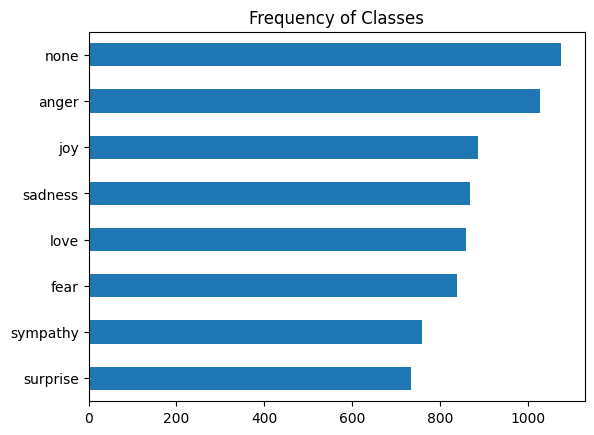

In [15]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How long are our tweets

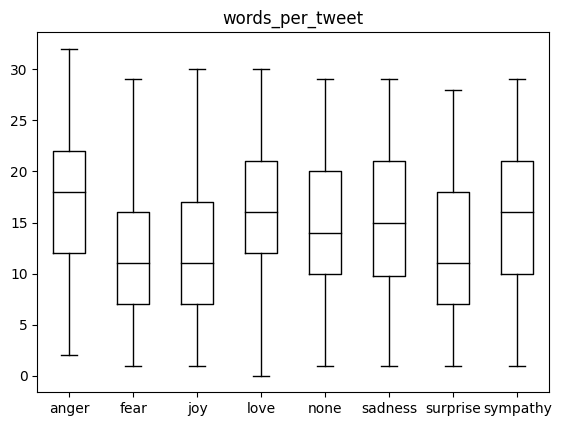

In [16]:
df["words_per_tweet"] = df["tweet"].str.split().apply(len)
df.boxplot(
    "words_per_tweet", by="label_name", grid=False, showfliers=False, color="black"
)

plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
emotions.reset_format()

### Tokenizing the whole dataset

In [18]:
from transformers import AutoTokenizer
from arabert.preprocess import ArabertPreprocessor

model_ckpt = "aubmindlab/bert-large-arabertv02"
arabert_prep = ArabertPreprocessor(model_name=model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tweet = df.values[0][0]
arabert_prep.preprocess(tweet)

'الطالب الوحيد ف تاريخ ستاراك اللي غنا لهحات ولغات مختلفه وابدع فيها محمد شاهين ليث المصري السادس كنزه حبيبه المصريين'

In [19]:
def apply_function_to_tweet_column(dataset):
    dataset = dataset.map(
        lambda example: {"tweet": arabert_prep.preprocess(example["tweet"])}
    )

    return dataset

for key in emotions.keys():
    emotions[key] = apply_function_to_tweet_column(emotions[key])

print(emotions)

Map:   0%|          | 0/7045 [00:00<?, ? examples/s]

Map:   0%|          | 0/3020 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 7045
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 3020
    })
})


In [20]:
def tokenize(batch):
    return tokenizer(batch['tweet'],padding=True,truncation=True)

In [21]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[2, 5394, 3691, 132, 1580, 12770, 1482, 1729, 30736, 181, 595, 1159, 39405, 302, 1259, 195, 48808, 232, 764, 582, 9907, 29941, 1568, 4727, 43891, 195, 6431, 195, 3661, 3, 0, 0], [2, 31, 1732, 16643, 2486, 2116, 5947, 16346, 181, 30341, 181, 3179, 49788, 7375, 103, 338, 7438, 8530, 28284, 195, 38856, 319, 45864, 319, 28971, 319, 105, 8, 105, 8, 12031, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [22]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x: x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,1,2,3,4


In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/7045 [00:00<?, ? examples/s]

Map:   0%|          | 0/3020 [00:00<?, ? examples/s]

In [24]:
print(emotions_encoded["train"].column_names)

['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


## Training a Text Classifier

### Transformers as feature extractors

In [25]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extract the last hidden states

In [26]:
tweet = "فاضل شهرين علي التخرج ومش مصدق نفسي! اخيرا هنتهي من وجع الدماغ"
inputs = tokenizer(tweet, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs

Input tensor shape: torch.Size([1, 16])


{'input_ids': tensor([[    2, 12038,  8117,   485, 18396,  5433, 50175,  6599,     8, 13887,
         58118,  1942,   306, 42151, 11403,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [27]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.0640,  1.6948,  1.0306,  ..., -1.1750,  0.5035, -0.6185],
         [-1.9549,  0.0626, -0.5692,  ...,  0.4556, -0.2298, -0.1585],
         [-2.9263,  0.4747, -0.8194,  ..., -1.5440, -0.6669,  0.6387],
         ...,
         [-2.2646, -0.1779, -0.2633,  ...,  0.9656,  0.0096,  0.4351],
         [ 0.4985,  2.0862, -0.7336,  ..., -0.8142, -0.2889,  0.1556],
         [-1.0640,  1.6948,  1.0306,  ..., -1.1750,  0.5035, -0.6185]]],
       device='cuda:0'), pooler_output=tensor([[-1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000]],
       device='cuda:0'), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)


In [28]:
outputs.last_hidden_state.size()

torch.Size([1, 16, 1024])

In [29]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 1024])

In [30]:
def extract_hidden_states(batch):
    inputs = {
        k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [31]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [32]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/7045 [00:00<?, ? examples/s]

Map:   0%|          | 0/3020 [00:00<?, ? examples/s]

In [33]:
emotions_hidden["train"].column_names

['tweet',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

### Creating feature matrix

In [34]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["test"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["test"]["label"])

X_train.shape, X_valid.shape

((7045, 1024), (3020, 1024))

### Visualizing the training set

In [35]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,0.710302,5.851313,2
1,0.598679,4.923792,6
2,19.169844,4.135794,2
3,0.336033,6.740733,0
4,19.653580,5.033214,2


### Training a simple classifier

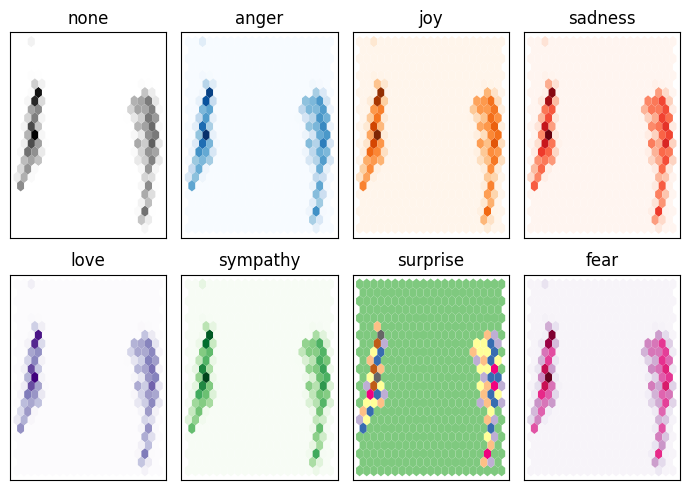

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "Accent", "PuRd"]
labels = emotions["train"].features["label"].names


for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb["X"], df_emb["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=3000)

In [38]:
lr_clf.score(X_valid,y_valid)

0.5294701986754967

In [39]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.15728476821192053

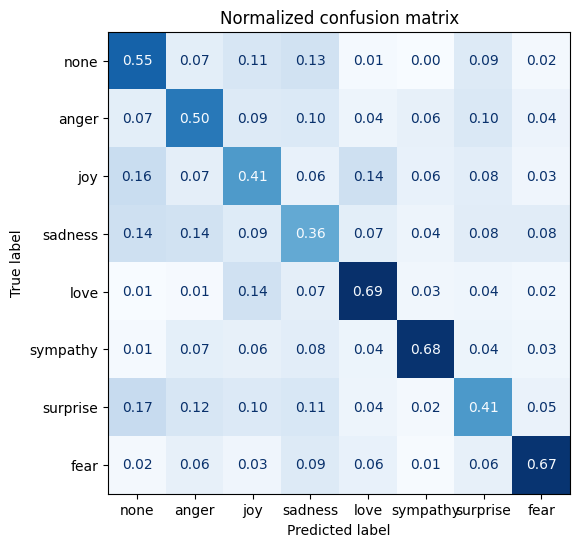

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning Transformers

### Loading a pretrained model

In [41]:
from transformers import AutoModelForSequenceClassification

num_labels = 8
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performace metrics

In [42]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

In [43]:
from huggingface_hub import notebook_login

notebook_login()

In [44]:
from transformers import Trainer, TrainingArguments
# import wandb
# wandb.init(mode=“disabled”)
batch_size = 4
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-arabic-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
    report_to="none"

)

In [45]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["test"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.103800,1.934113
2,1.134100,0.876158


TrainOutput(global_step=3524, training_loss=1.6191194809795644, metrics={'train_runtime': 1397.2553, 'train_samples_per_second': 10.084, 'train_steps_per_second': 2.522, 'total_flos': 1359282212438880.0, 'train_loss': 1.6191194809795644, 'epoch': 2.0})

In [46]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [48]:
# Convert our dataset back to Pytorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Compute loss values
emotions_encoded["test"] = emotions_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/3020 [00:00<?, ? examples/s]

In [51]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7045
    })
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 3020
    })
})

In [52]:
emotions_encoded.set_format("pandas")

cols = ["tweet", "label", "predicted_label", "loss"]
df_test = emotions_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [53]:
df_test.sort_values("loss", ascending=False).head(10)

,tweet,label,predicted_label,loss
363,خايف لاتكوني مش بتاعتي,sadness,fear,6.307064
2812,: وده الي كنت خايف منه ? ? خلصو علي فلسطين وشا...,sadness,fear,5.880860
160,عارف لما تكون كل يوم بتعيط علشان خايف من حاجه ...,sadness,fear,5.820791
1128,بعد الاوليمبياد ده غالبا احنا اللي هيتقالنا ع ...,fear,none,5.395926
2859,فيه لاعب جودو مصري هيلاعب واحد اسرائيلي في الا...,fear,none,5.165072
500,لو حصل و خرج هيبقي اكبر فشل في الاوليمبياد,fear,none,5.139538
1364,الخوف بالف نصل كل نصل ينغرس في حلم قادم فتسود ...,sadness,fear,5.076986
2,طب هنعيش ازاي من غير رفع اثقال من هنا لحد الاو...,fear,none,5.066395
158,شفتوا اللي تدخل عصها بشيء مايخصها مثلها مثل رو...,none,anger,5.064074
589,الاوليمبياد مزفته التايملاين,anger,none,4.979183


In [54]:
trainer.push_to_hub(commit_message="Training completed!")

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Abdelkareem/bert-large-arabertv02-arabic-finetuned-emotion/commit/d70554a5bb78dc9c20145e44e7b5f47ba16a753a', commit_message='Training completed!', commit_description='', oid='d70554a5bb78dc9c20145e44e7b5f47ba16a753a', pr_url=None, pr_revision=None, pr_num=None)

### Saving and sharing the model


In [55]:
from transformers import pipeline

# Change "transformerbook" to Hub username
model_id = f"Abdelkareem/bert-large-arabertv02-arabic-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/761k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [56]:
custom_tweet = "ما تيجي وانا احبك احبك :)"
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


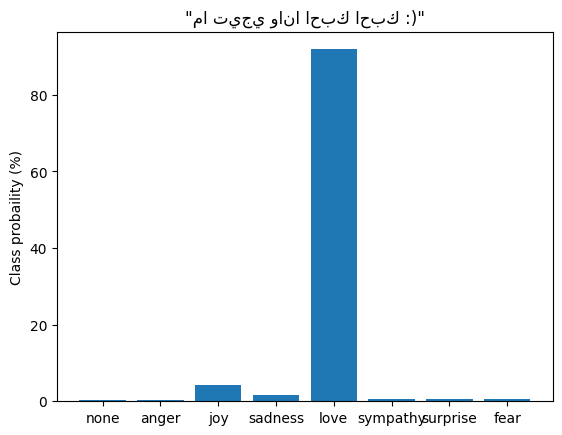

In [57]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probaility (%)")
plt.show()